# Using Variational Autoencoder to create new imagems

## Background

We have two examples of puppies from which we want to identify the probable cracks that led to their creation. To do this, we will train a model with interpolation capabilities between the encoder and the decoder.

The project was made possible according to the [proposed planning](../docs/planning.md)

## Measure of Success

Validation will be done through visualization by identifying similarities between the breeds.

# 0.0 Imports

In [13]:
from zipfile import ZipFile
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from PIL import Image

import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

import sys
sys.path.append("../src/")
from models.vae import VAE

## 0.1 Load Data

In [13]:
zip_path = '../data/01_raw/train.zip'
extract_to = '../data/01_raw/'

with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

## 0.2 Helper Functions

# 1.0 Prepare Data

- I'm going to upload the image labels for better identification, and I'm going to make very simple transformations for this first version.

In [4]:
df = pd.read_csv('../data/01_raw/labels.csv')
synset = sorted(set(df['breed']))
n = len(df)

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

X = torch.zeros((n, 3, 64, 64), dtype=torch.float)
y = torch.zeros((n,), dtype=torch.long)

for i, (fname, breed) in tqdm(df.iterrows(), total=n):
    img_path = f'../data/01_raw/{fname}.jpg'
    img = Image.open(img_path).convert('RGB')
    img = transform(img)
    X[i] = img
    y[i] = synset.index(breed)

dataset = TensorDataset(X, y)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

100%|██████████| 10222/10222 [00:16<00:00, 638.02it/s]


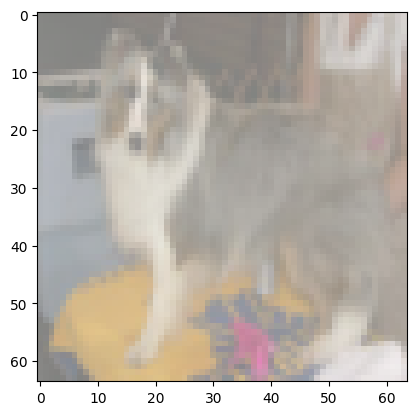

In [5]:
sample_images, _ = next(iter(data_loader))

plt.imshow((sample_images[0].numpy().transpose(1, 2, 0)+1)/2)
plt.show()

# 2.0 Variational Autoencoder

- I'm going to use a model built by this [repository](https://github.com/atinghosh/VAE-pytorch)

In [7]:
lr = 0.001
epochs = 8
latent_dim = 32
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VAE(latent_dim, batch_size=batch_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

## 2.1 Machine Learning

In [ ]:
for epoch in range(1, epochs+1):
    model.train()
    print(f'Epoch {epoch} start')
    
    for data in data_loader:
        imgs, _ = data
        imgs = imgs.to(device)
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(imgs)
        loss = model.loss_function(recon_batch, imgs, mu, logvar)

        loss.backward()
        optimizer.step()
        
    model.eval()
    recon_img, _, _ = model(sample_images[:1].to(device))
    img = recon_img.view(3, 64, 64).detach().cpu().numpy().transpose(1, 2, 0)
    
    plt.imshow((img+1.)/2.)
    plt.show()

In [1]:
model_path = '../data/06_models/model_vae.pth'
torch.save(model.state_dict(), model_path)

In [ ]:
model = VAE(latent_dim=latent_dim, batch_size=batch_size)

model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

model.to(device)

model.eval()